<center> <h1>Αναγνώριση Προτύπων - 3η Εργαστηριακή Άσκηση</h1> </center>

---

<center> <h2>Θέμα: Αναγνώριση Είδους και Εξαγωγή Συναισθήματος από Μουσική</h2> </center>
<center> <h2>ΣΧΟΛΗ: ΣΗΜΜΥ</h2> </center>

Ονοματεπώνυμο | Αριθμός Μητρώου
------------ | -------------
Γιάννης Πιτόσκας | 03115077
Αντώνης Παπαοικονόμου | 03115140

# Βήμα 0

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

data_path = "../input/patreco3-multitask-affective-music/data/"
# data_path = os.path.abspath("Q:\Files\patreco3-multitask-affective-music\data")
# data_path = os.path.abspath("/Volumes/Ext HDD/Files/patreco3-multitask-affective-music/data")

print(os.listdir(data_path))

['multitask_dataset_beat', 'multitask_dataset', 'fma_genre_spectrograms_beat', 'fma_genre_spectrograms']


# Βήμα 1

Με βάση τον κώδικα που έχουμε από το [Data Loading Tutorial](https://www.kaggle.com/geoparslp/data-loading-tutorial/data):

In [2]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, self.gold_labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(self.gold_labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(self.gold_labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], self.gold_labels[item], l

    def __len__(self):
        return len(self.labels)

**(β)** Διαβάζοντας τα αρχεία από το path `/fma_genre_spectrograms/` έχουμε:

In [3]:
fma_genre_spectr_path = os.path.join(data_path, "fma_genre_spectrograms")

# print(os.listdir(fma_genre_spectr_path))
    
train_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_mel))

test_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_mel))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


**(α)** Παρακάτω επιλέγουμε δυο τυχαία δείγματα με διαφορετικά labels τα οποία και θα χρησιμοποιήσουμε και για τα επόμενα ερωτήματα για να έχουμε consistancy και να μπορούμε να τα συγκρίνουμε μεταξύ τους.

In [4]:
import random

sr = 22050

rand_index_1 = random.randint(0, len(train_specs_mel)-1)
rand_index_2 = random.randint(0, len(train_specs_mel)-1)
rand_sample_1 = train_specs_mel[rand_index_1]
rand_sample_2 = train_specs_mel[rand_index_2]
while rand_sample_2[1] == rand_sample_1[1]:
    rand_index_2 = random.randint(0, len(train_specs_mel)-1)
    rand_sample_2 = train_specs_mel[rand_index_2]

l1 = rand_sample_1[3]
l2 = rand_sample_2[3]

# print(specs_fused.label_transformer.inverse_transform([rand_sample_1[1]]))
# print(rand_sample_1[2])
# print(rand_sample_2[2])
# print(rand_sample_1[0].shape)
# print(rand_sample_2[0].shape)
# print(rand_sample_1[3])
# print(rand_sample_2[3])

**(γ)** Παρακάτω έχουμε τα φασματογραφήματα για τα τυχαία δείγματα:

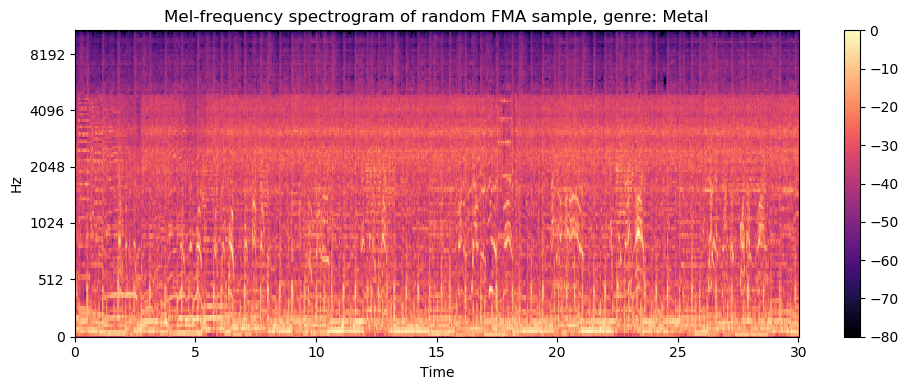

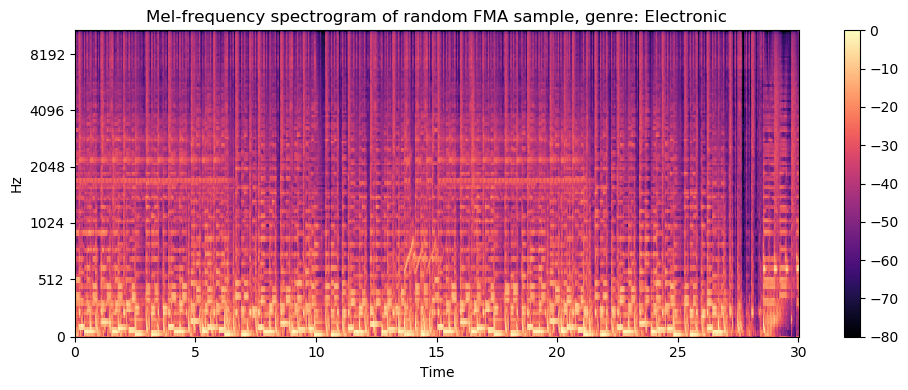

In [5]:
%matplotlib inline
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()

# rand_sample_1_audio = librosa.feature.inverse.mel_to_audio(rand_sample_1[0])
# IPython.display.Audio(rand_sample_1_audio, rate=sr)

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# rand_sample_2_audio = librosa.feature.inverse.mel_to_audio(rand_sample_2[0])
# IPython.display.Audio(rand_sample_2_audio, rate=sr)

>Τα παραπάνω διαγράμματα μας δίνουν πληροφορία για τις συχνότητες που χρησιμοποιούνται σε κάθε τραγούδι, συναρτήσει του χρόνου καθώς και για την ένταση (πλάτος) των συχνοτήτων αυτών, ενώ δεν περιέχουν καμία πληροφορία για την φάση (κάτι που συνιστά την ανακαστακευή του ήχου μόνο από το φασματογράφημα ανακριβή)

# Βήμα 2

**(α)** Τα χρονικά βήματα είναι η πρώτη διάσταση του πίνακα των features που φαίνεται παρακάτω και είναι ίση με $1293$ (με zero-padding)

In [6]:
print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(1293, 128)
(1293, 128)


>Παρατηρούμε πως το μέγεθος του παραπάνω πίνακα είναι αρκετά μεγάλο κάτι το οποίο θα έχει σημαντική επίδραση στον χρόνο εκπαίδευσης ενός `LSTM` και άρα αυτό το καθιστά μη αποδοτικό.

**(β)** Διαβάζοντας τα αρχεία από το path `/fma_genre_spectrograms_beat/` έχουμε:

In [7]:
fma_genre_spectr_beat_path = os.path.join(data_path, "fma_genre_spectrograms_beat")
    
train_specs_beat_mel = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_beat_mel))

test_specs_beat_mel = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_beat_mel))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [8]:
# rand_sample_1 = train_specs_beat_mel[rand_index_1]
# rand_sample_2 = train_specs_beat_mel[rand_index_2]

# l1 = rand_sample_1[3]
# l2 = rand_sample_2[3]

# print(rand_sample_1[0].shape)
# print(rand_sample_2[0].shape)

In [9]:
# import IPython.display
# import librosa.display
# import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 100

# sr = 22050

# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
# librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar()
# plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_1[2])
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
# librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar()
# plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_2[2])
# plt.tight_layout()
# plt.show()

# Βήμα 3

Για τα χρωμογραφήματα που περιέχουν πληροφορίες σχετικά με τις νότες του κάθε τραγουδιού έχουμε:

Για την πλήρη πληροφορία:

In [10]:
# chromas_train = SpectrogramDataset(
#      fma_genre_spectr_path,
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)

# print("Train Loaded Successfuly.", "Train data length:", len(chromas_train))

# chromas_test = SpectrogramDataset(
#      fma_genre_spectr_path,
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)

# print("Test Loaded Successfuly.", "Test data length:", len(chromas_test))

In [11]:
# rand_sample_1 = chromas_train[rand_index_1]
# rand_sample_2 = chromas_train[rand_index_2]

# l1 = rand_sample_1[3]
# l2 = rand_sample_2[3]

# print(rand_sample_1[0].shape)
# print(rand_sample_2[0].shape)

In [12]:
# import IPython.display
# import librosa.display
# import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 100

# sr = 22050

# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
# librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='chroma')
# plt.colorbar()
# plt.title('Chroma of random FMA sample, genre: '+rand_sample_1[2])
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
# librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='chroma')
# plt.colorbar()
# plt.title('Chroma of random FMA sample, genre: '+rand_sample_2[2])
# plt.tight_layout()
# plt.show()

Για τα beat-synced δεδομένα:

In [13]:
# chromas_beat_train = SpectrogramDataset(
#      fma_genre_spectr_beat_path,
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)

# print("Train Loaded Successfuly.", "Train data length:", len(chromas_beat_train))

# chromas_beat_test = SpectrogramDataset(
#      fma_genre_spectr_beat_path,
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)

# print("Test Loaded Successfuly.", "Test data length:", len(chromas_beat_test))

In [14]:
# rand_sample_1 = chromas_beat_train[rand_index_1]
# rand_sample_2 = chromas_beat_train[rand_index_2]

# l1 = rand_sample_1[3]
# l2 = rand_sample_2[3]

# print(rand_sample_1[0].shape)
# print(rand_sample_2[0].shape)

In [15]:
# import IPython.display
# import librosa.display
# import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 100

# sr = 22050

# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
# librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='chroma')
# plt.colorbar()
# plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_1[2])
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=(10, 4))
# # S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
# librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='chroma')
# plt.colorbar()
# plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_2[2])
# plt.tight_layout()
# plt.show()

# Βήμα 4

**(α)** Στη συνέχεια γίνεται χρήση της προαναφερθείσας έτοιμης υλοποίησης `PyTorch Dataset` η οποία διαβάζει τα δεδομένα και επιστρέφει τα δείγματα. Παρατηρούμε πως αφού τα δείγματα μας δεν έχουν όλα το ίδιο πλήθος features είναι απαραίτητη η χρήση του `zero padding`, μιας και για το στάδιο της εκπαίδευσης του `LSTM` πρέπει όλα τα δεδομένα να έχουν όλα τις ίδιες διαστάσειες. Στην επιστροφή των δεδομένων μέσω του getter που έχει οριστεί, εκτός από τα features, τα μετασχηματισμένα labels (σε Integers) και το πραγματικό μήκος του κάθε δείγματος (χωρίς zero-padding δηλαδή) έχουμε προσθέσει και την πραγματική τιμή του label ως string (του genre).

**(β)** Με την παράμετρο `class_mapping` κάνουμε **_map_** μερικές κλάσεις σε κάποιες ήδη υπάρχουσες που μπορούν να θεωρηθούν ευρύτερες με σκοπό την συγχώνευση όμοιων μεταξύ τους κλάσεων, ή αφαιρούμε εντελώς αυτές που παρατηρούμε ότι αντιπροσωπεύονται από πολύ μικρό αριθμό δειγμάτων.

In [16]:
# specs_without_mapping = SpectrogramDataset(
#      fma_genre_spectr_path,
#      train=True,
#      class_mapping={},
#      max_length=-1,
#      read_spec_fn=read_mel_spectrogram)

# print("Train Loaded Successfuly.", "Train data length:", len(specs_without_mapping))

**(γ)** Παρακάτω φαίνονται τα ιστογράμματα που αφορούν τον αριθμό δειγμάτων που αντιστοιχούν στην εκάστοτε κλάση **χωρίς** και **με** συγχώνευση κλάσεων:

In [17]:
# # Initialize subplots
# fig, axs = plt.subplots(1,2,figsize=(20,7))
# fig.suptitle("Number of Samples per Genre", size=22, fontweight='demibold' )

# # Before Class Merging
# unique, counts = np.unique(specs_without_mapping.gold_labels, return_counts=True)
# axs[0].set_title("(a) Without Genre-Merging", size=15)
# axs[0].bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
# [tick.set_rotation(90) for tick in axs[0].get_xticklabels()]
# axs[0].tick_params(labelsize=17)
# axs[0].grid(linewidth=0.3, alpha=0.5)

# # After Class Merging
# unique, counts = np.unique(train_specs_mel.gold_labels, return_counts=True)
# axs[1].set_title("(b) With Genre-Merging", size=15)
# axs[1].bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
# [tick.set_rotation(90) for tick in axs[1].get_xticklabels()]
# axs[1].tick_params(labelsize=17)
# axs[1].grid(linewidth=0.3, alpha=0.5)

# plt.show()

# Βήμα 5-6

Παρακάτω έχουμε μια υλοποίηση για ένα `LSTM` δίκτυο:

In [18]:
import torch
from torch import nn

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.0, 
                 num_layers=1, bidirectional=False, isPackedSequence=False):
        super(BasicLSTM, self).__init__()
        
        self.dropout_prob = dropout_prob
        self.bidirectional = bidirectional
        self.feature_size = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.isPackedSequence = isPackedSequence
        
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                                dropout=dropout_prob, batch_first=True, bidirectional= bidirectional)
        
        self.drop = nn.Dropout(p=dropout_prob)
        
        self.fc = nn.Linear(self.feature_size, self.output_dim)
        

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        N, L, D = x.size()
        
        if self.isPackedSequence:
            x = pack_padded_sequence(x, lengths, batch_first=True)
        
        out, _ = self.lstm(x)
        
        if self.isPackedSequence:
            out, _ = pad_packed_sequence(out, batch_first=True)
        
        dropped = self.drop(out)
        
        last = self.last_timestep(dropped, lengths)
        
        last_outputs = self.fc(last)
        
        # You must have all of the outputs of the LSTM
        # but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
              
        return last_outputs
    
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [19]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...\n\n')
        torch.save(model, 'checkpoint.pt')
        self.val_loss_min = val_loss

In [20]:
import math
import sys

def progress(loss, epoch, batch, batch_size, dataset_size):
    """
    Print the progress of the training for each epoch
    """
    batches = math.ceil(float(dataset_size) / batch_size)
    count = batch * batch_size
    bar_len = 40
    filled_len = int(round(bar_len * count / float(dataset_size)))

    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    status = 'Epoch {}, Loss: {:.4f}'.format(epoch, loss)
    _progress_str = "\r \r [{}] ...{}".format(bar, status)
    sys.stdout.write(_progress_str)
    sys.stdout.flush()

    if batch == batches:
        print()

In [21]:
import torch
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def train_dataset(_epoch, dataloader, model, loss_function, optimizer, classification=True, label_index=1):
    
    model.train()
    running_loss = 0.0

    # obtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):

        # get the inputs (batch)
        inputs = batch[0]
        labels = batch[label_index]
        lengths = batch[-1]
        
        # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
        inputs = Variable(inputs).to(device).float()
        labels = Variable(labels).to(device)
        lengths = Variable(lengths).to(device)

        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths).double()

        # Step 3 - compute loss: L = loss_function(y, y')
        if (classification):
            loss = loss_function(outputs, labels)
        else:
            loss = loss_function(outputs.view(-1), labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        running_loss += loss.data.item()

        # print statistics
        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))

    return running_loss / index


def eval_dataset(dataloader, model, loss_function, classification=True, label_index=1):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs = batch[0]
            labels = batch[label_index]
            lengths = batch[-1]
            

            # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence     
            inputs = Variable(inputs).to(device).float()
            labels = Variable(labels).to(device)
            lengths = Variable(lengths).to(device)
                    
            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths).double()

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            if (classification):
                loss = loss_function(outputs, labels)
            else:
                loss = loss_function(outputs.view(-1), labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            values, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            if (classification):
                y_pred.extend(list(posibol.data.cpu().numpy().squeeze()))
            else:
                y_pred.extend(list(values.data.cpu().numpy().squeeze()))
            
            y.extend(list(labels.data.cpu().numpy().squeeze()))


            running_loss += loss.data.item()

    return running_loss / index, (y_pred, y)

In [22]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_val_model(EPOCHS, train_loader, val_loader, model, loss_function, optimizer, early_stopping_limit=0, 
                        classification=True, label_index=1):

    total_train_loss = []
    total_val_loss = []
    
    if early_stopping_limit:
        early_stopping = EarlyStopping(patience=early_stopping_limit, verbose=True)
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        # train the model for one epoch
        train_dataset(epoch, train_loader, model, loss_function, optimizer, classification, label_index)

        # evaluate the performance of the model
        train_loss, (y_train_pred, y_train_gold) = eval_dataset(train_loader, model, loss_function, classification, label_index)
        print("Train Set: loss={:.4f}".format(train_loss))
        
        val_loss, (y_val_pred, y_val_gold) = eval_dataset(val_loader, model, loss_function, classification, label_index)
        if (classification):
            print("Validation Set: loss={:.4f}, accuracy={:.4f}\n".format(val_loss, 
                                                                      accuracy_score(y_val_gold, y_val_pred)))
        else:
            print("Validation Set: loss={:.4f}\n".format(val_loss))


        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        
        if early_stopping_limit:
            early_stopping(val_loss, model)
        
            if early_stopping.early_stop:
                print("Early stopping...")
                break

    if early_stopping_limit:        
        # load the last checkpoint with the best model
#         model.load_state_dict(torch.load('checkpoint.pt'))
        model = torch.load('checkpoint.pt')
    
    time_elapsed = time.time() - start_time
    print("\nTotal train and validation time: {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    
    return total_train_loss, total_val_loss


def test_model(test_loader, model, loss_function, set, classification=True, label_index=1):
    
    test_loss, (y_test_pred, y_test_gold) = eval_dataset(test_loader, model, loss_function, classification, label_index)
    print("\n"+set+" Set: loss={:.4f}, accuracy={:.4f}, f1-macro={:.4f}".format(test_loss,
                accuracy_score(y_test_gold, y_test_pred), f1_score(y_test_gold, y_test_pred, average='macro')))
    
    return y_test_pred, y_test_gold

In [23]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Για την εκπαίδευση των παρακάτω δεδομένων θα χρησιμοποιήσουμε ένα `Bidirectional LSTM` δίκτυο με δύο layers, $batch\ size = 64$ και με την εκπαίδευση να γίνεται για $25$ εποχές.

In [24]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 25

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0.130 
n_cuda = 1 
Cuda Name(s): Tesla P100-PCIE-16GB


Για το διαχωρισμό των δεδομένων σε train και validation με ποσοστα $80\%-20\%$ θα κάνουμε χρήση της συνάρτησης `train_test_split()` της βιβλιοθήκης `sklearn`

**(α)** Έχονντας ως  είσοδο τα __φασματογραφήματα__ του συνόλου εκπαίδευσης έχουμε:

In [25]:
# from sklearn.model_selection import train_test_split

# train_specs, val_specs = train_test_split(train_specs_mel, test_size=0.2)

# train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_specs_mel, batch_size=BATCH_SIZE, shuffle=True)

# INPUT_SIZE = train_specs_mel.feat_dim
# OUTPUT_SIZE = len(list(set(train_specs_mel.labels)))

# model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
#                                                         loss_function, optimizer)

In [26]:
# y_val_pred, y_val_gold = test_model(val_loader, model, loss_function, "Validation")

In [27]:
# y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")

In [28]:
# from sklearn.metrics import classification_report

# labels = list(set(test_specs_mel.gold_labels))
# print(classification_report(y_test_gold, y_test_pred, target_names=labels))

In [29]:
# from sklearn.metrics import confusion_matrix


# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

# conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
# plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(β)** Έχονντας ως  είσοδο τα __beat-synced spectrograms__ του συνόλου εκπαίδευσης έχουμε:

In [30]:
# from sklearn.model_selection import train_test_split

# train_specs, val_specs = train_test_split(train_specs_beat_mel, test_size=0.2)

# train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_specs_beat_mel, batch_size=BATCH_SIZE, shuffle=True)

# INPUT_SIZE = train_specs_beat_mel.feat_dim
# OUTPUT_SIZE = len(list(set(train_specs_beat_mel.labels)))

# model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
#                                                         loss_function, optimizer)

In [31]:
# y_val_pred, y_val_gold = test_model(val_loader, model, loss_function, "Validation")

In [32]:
# y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")

In [33]:
# from sklearn.metrics import classification_report

# labels = list(set(test_specs_mel.gold_labels))
# print(classification_report(y_test_gold, y_test_pred, target_names=labels))

In [34]:
# from sklearn.metrics import confusion_matrix

# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

# conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
# plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(γ)** Έχονντας ως  είσοδο τα __χρωμογραφήματα (beat-synced)__ του συνόλου εκπαίδευσης έχουμε:

In [35]:
# from sklearn.model_selection import train_test_split

# train_specs, val_specs = train_test_split(chromas_beat_train, test_size=0.2)

# train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(chromas_beat_test, batch_size=BATCH_SIZE, shuffle=True)

# INPUT_SIZE = chromas_beat_train.feat_dim
# OUTPUT_SIZE = len(list(set(chromas_beat_train.labels)))

# model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
#                                                         loss_function, optimizer)

In [36]:
# y_val_pred, y_val_gold = test_model(val_loader, model, loss_function, "Validation")

In [37]:
# y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")

In [38]:
# from sklearn.metrics import classification_report

# labels = list(set(test_specs_mel.gold_labels))
# print(classification_report(y_test_gold, y_test_pred, target_names=labels))

In [39]:
# from sklearn.metrics import confusion_matrix

# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

# conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
# plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(δ) (Bonus)** Έχονντας ως  είσοδο τα __concatenated (beat-synced) features__ του συνόλου εκπαίδευσης έχουμε:

In [40]:
train_specs_fused = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_fused))

test_specs_fused = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_fused))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [41]:
from sklearn.model_selection import train_test_split

train_specs, val_specs = train_test_split(train_specs_fused, test_size=0.2)

# train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_specs_fused, batch_size=BATCH_SIZE, shuffle=True)

# INPUT_SIZE = train_specs_fused.feat_dim
# OUTPUT_SIZE = len(list(set(train_specs_fused.labels)))

# model_lstm = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

# total_train_loss, total_val_loss = train_and_val_model(50, train_loader, val_loader, model_lstm, 
#                                                         loss_function, optimizer)

In [42]:
# y_val_pred, y_val_gold = test_model(val_loader, model_lstm, loss_function, "Validation")

In [43]:
# y_test_pred, y_test_gold = test_model(test_loader, model_lstm, loss_function, "Test")

In [44]:
# from sklearn.metrics import classification_report

# labels = list(set(test_specs_mel.gold_labels))
# print(classification_report(y_test_gold, y_test_pred, target_names=labels))

In [45]:
# from sklearn.metrics import confusion_matrix

# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

# conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
# plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

>Παρατηρούμε πως συγκρίνοντας τους χρόνους εκπαίδευσης και παρατηρώντας τις μετρικές στο εκάστοτε test set δεν έχει νόημα η εκπαίδευση στα full data. Παρατηρούμε επίσης πως χρησιμοποιώντας την ίδια αρχιτεκτονική αλλά δίνοντας ως input τα concatenated beat-synced features, πετυχαίνουμε αρκετά καλύτερη επίδοση σε σχέση με όλες τις προηγούμενες δοκιμές κατι αναμενόμενο μιας και πρόκειται για συνδυασμό γνώσης/features.

# Βήμα 6

**(δ)** Το `Accuracy` ενός μοντέλου πάνω σε ένα σύνολο δεδομένων δείχνει τι ποσοστό των προβλέψεων είναι σωστές και το ορίζουμε ως εξής:

$$Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}$$



Θεωρούμε μια οποιαδήποτε κλάση $c$ θετική (possitive) και όλες τις υπόλοιπες αρνητικές (negative). Ορίζουμε τα παρακάτω:

- True Positive (**TP**): Είναι το πλήθος των δειγμάτων για τα οποία το μοντέλο προβλέπει σωστά ότι ανήκουν στην θετική κλάση.

- True Negative (**TN**): Είναι το πλήθος των δειγμάτων για τα οποία το μοντέλο προβλέπει σωστά ότι δεν ανήκουν στη θετική κλάση.

- False Positive (**FP**): Είναι το πλήθος των δειγμάτων για τα οποία το μοντέλο προβλέπει λανθασμένα ότι ανήκουν στην θετική κλάση.

- False Negative (**FN**): Είναι το πλήθος των δειγμάτων για τα οποία το μοντέλο προβλέπει λανθασμένα ότι δεν ανήκουν στην θετική κλάση. 


Το `Precision` για την κλάση $c$ ενός μοντέλου πάνω σε ένα σύνολο δεδομένων δείχνει τι ποσοστό των θετικών προβλέψεων ήταν πραγματικά σωστές και το ορίζουμε ως εξής:

$$Precision(c) = \frac{TP}{TP+FP}$$

Το `Recall` για την κλάση $c$ ενός μοντέλου πάνω σε ένα σύνολο δεδομένων δείχνει τι ποσοστό των δεδομένων που ανήκουν στην θετική κλάση πράγματι προβλέφθηκε σωστά και το ορίζουμε ως εξής:

$$Recall(c) = \frac{TP}{TP+FN}$$

Το `F1-score` για την κλάση $c$ ενός μοντέλου πάνω σε ένα σύνολο δεδομένων είναι ένα μέτρο της ακρίβειας το οποίο εξαρτάται από τα Precision και Recall και μάλιστα ορίζεται ως ο αρμονικός τους μέσος:

$$F1-score(c) = 2\cdot\frac{Precision \cdot Recall}{Precision+Recall}$$


Στην περίπτωση του `Macro-Average` υπολογίζουμε μια μετρική επιτυχίας, μεταχειριζόμενοι όλες τις κλάσεις ισότιμα, παρά το διαφορετικό πλήθος δεδομένων που πιθανότατα αντιστοιχεί στην καθεμία. Ουσιαστικά, τα `Macro-Averaged` `Precision` και `Recall` ορίζονται αντίστοιχα ως ο μέσος όρος των επιμέρους $Precision(c)$ και $Recall(c)$ και εν συνεχεία το `Macro-Averaged` `F1-score` ορίζεται ως ο αρμονικός μέσος των `Macro-Averaged` `Precision` και `Recall`.

Στην περίπτωση του `Micro-Average` υπολογίζουμε μια μετρική επιτυχίας, λαμβάνοντας υπόψη τη συνεισφορά της κάθε κλάσης. Ουσιαστικά, τα `Micro-Averaged` `Precision`, `Recall` και `F1-score` ισούνται όλα με το `Accuracy` που ορίσαμε παραπάνω.




Στην περίπτωση του `Macro-Average`, το `F1-score` ενδέχεται να απέχει πολύ από το `Accuracy`. Αυτό μπορεί να συμβεί εάν η συνεισφορά της κάθε κλάσης στο σύνολο των δεδομένων είναι αρκετά ανισομερής.

Αντιθέτως, στην περίπτωση του `Micro-Average`, το `F1-score` είναι αδύνατο να αποκλίνει από το `Accuracy` μιας και ταυτίζονται. 

Η περίπτωση που τα `Macro-Averaged F1-score` και `Micro-Averaged F1-score` αποκλίνουν οφείλεται σε ανισομερή συνεισφορά της εκάστοτε κλάσης, πράγμα που ταυτίζεται με την παραπάνω πρόταση πέρι απόκλισης `Macro-Average F1-score` και `Accuracy` μιας και τα `Micro-Averaged F1-score` και `Accuracy` αποτελούν το ίδιο πράγμα.



Αρχικά, γνωρίζουμε ότι δε μπορούμε να μεγιστοποιήσουμε και το Precision και το Recall ενός μοντέλου, βελτιώνοντας το ένα θα χειροτερεύει το άλλο. Βέβαια, ανάλογα με το πρόβλημα μερικές φορές το Recall μας ενδιαφέρει περισσότερο από το Precision και αντιστρόφως Για παράδειγμα, ένα μοντέλο για να αποφανθούμε αν ένας ασθενής έχει ένα σπάνιο είδος καρκίνου πρέπει οπωσδήποτε να έχει υψηλό Recall, καθώς επιθυμούμε οπωσδήποτε να ελαχιστοποιηθούν τα False Negatives. Από την άλλη, ένα μοντέλο για να κάνει συστάσεις βίντεο στους χρήστες μιας διαδικτυακής πλατφόρμας προτιμάμε να έχει υψηλό Precision αφού θέλουμε ελαχιστοποίηση των False Positives (και τα False Negatives δε μας αφορούν ιδιαίτερα).

Κάποιο είδος `Averaged F1-score` (είτε το Accuracy) είναι αρκετό για την επιλογή μοντέλου όταν αναζητούμε μια ισορροπία μεταξύ των Precision και Recall. Ωστόσο, σε πολύ ειδικές περιπτώσεις που είναι αναγαίο να ελαχιστοποιηθούν όσο γίνεται περισσότερο είτε τα False Negatives,  είτε τα False Positives τότε θα πρέπει να επικεντρωθούμε στην μεγιστοποίηση του Recall και του Precision αντίστοιχα.

# Βήμα 7

**(α)** Από τα παρακάτω στιγμιότυπα από την εκπαίδευση ενός CNN στο MNIST dataset (μέσω του [ConvNetJS](https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html)) έχουμε:

**(β)** Για το 4 layer 2D CNN έχουμε:

In [46]:
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class ConvNNet(Module):   
    def __init__(self, in_channels, out_channels, Hin, Win, out_dim, cnn_kernel_size, mp_kernel_size, cnn_stride=1, mp_stride=1,
                                                                     cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1):  
        super(ConvNNet, self).__init__()
        
        
        self.cnn_Hout = int((Hin + 2*cnn_padding - cnn_dilation*(cnn_kernel_size-1) - 1)/cnn_stride + 1)
        self.cnn_Wout = int((Win + 2*cnn_padding - cnn_dilation*(cnn_kernel_size-1) - 1)/cnn_stride + 1)
           
        self.mp_Hout = int((self.cnn_Hout + 2*mp_padding - mp_dilation*(mp_kernel_size-1) - 1)/mp_stride + 1)
        self.mp_Wout = int((self.cnn_Wout + 2*mp_padding - mp_dilation*(mp_kernel_size-1) - 1)/mp_stride + 1)
        
        
        self.cnn_layers = Sequential(
            Conv2d(in_channels, out_channels, kernel_size=cnn_kernel_size, stride=cnn_stride, padding=cnn_padding, dilation=cnn_dilation),
            BatchNorm2d(out_channels),
            ReLU(),
            MaxPool2d(kernel_size=mp_kernel_size, stride=mp_stride, padding=mp_padding, dilation=mp_dilation)
        )

        self.linear = Linear(out_channels*self.mp_Hout*self.mp_Wout, out_dim)

        
    # Defining the forward pass    
    def forward(self, x, lengths):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
#         x = torch.sigmoid(x)
        
        return x

In [47]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 3

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0.130 
n_cuda = 1 
Cuda Name(s): Tesla P100-PCIE-16GB


In [48]:
from sklearn.model_selection import train_test_split

train_specs, val_specs = train_test_split(train_specs_mel, test_size=0.2)

train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_specs_mel, batch_size=BATCH_SIZE, shuffle=True)

INPUT_HEIGHT = train_specs_mel.max_length
INPUT_WIDTH = train_specs_mel.feat_dim
OUTPUT_SIZE = len(list(set(train_specs_mel.labels)))

model_cnn = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-4)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_cnn, 
                                                        loss_function, optimizer)

 [========================================] ...Epoch 1, Loss: 2.2917
Train Set: loss=1.8911
Validation Set: loss=2.2372, accuracy=0.2885

 [========================================] ...Epoch 2, Loss: 1.7943
Train Set: loss=1.6567
Validation Set: loss=2.0003, accuracy=0.3232

 [========================================] ...Epoch 3, Loss: 1.7053
Train Set: loss=1.3724
Validation Set: loss=1.8661, accuracy=0.3449


Total train and validation time: 0m 26s


In [49]:
y_test_pred, y_test_gold = test_model(test_loader, model_cnn, loss_function, "Test")


Test Set: loss=2.0247, accuracy=0.2939, f1-macro=0.2491


In [50]:
from sklearn.metrics import classification_report

labels = list(set(test_specs_mel.gold_labels))
print(classification_report(y_test_gold, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

  Electronic       0.30      0.07      0.12        40
        Rock       0.43      0.55      0.48        40
     Hip-Hop       0.52      0.33      0.40        80
        Jazz       0.33      0.31      0.32        80
    Trip-Hop       0.25      0.03      0.05        40
       Metal       0.16      0.17      0.16        40
         Pop       0.28      0.29      0.29        78
       Blues       0.05      0.07      0.06        40
   Classical       0.30      0.51      0.38       103
        Folk       0.33      0.18      0.23        34

    accuracy                           0.29       575
   macro avg       0.30      0.25      0.25       575
weighted avg       0.31      0.29      0.28       575



# Βήμα 8

**(α)** Για το multitask dataset:

In [51]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class MultitaskDataset(Dataset):
    def __init__(self, path, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        if train:
            self.index = os.path.join(path, "{}_labels.txt".format(t))
            self.files, self.valences, self.energies, self.danceabilities = self.get_files_labels(self.index)
        else:
            self.files, self.valences, self.energies, self.danceabilities = os.listdir(p), [0]*(len(os.listdir(p))), [0]*(len(os.listdir(p))), [0]*(len(os.listdir(p)))
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)

    def get_files_labels(self, txt):
        files, valences, energies, danceabilities = [], [], [], []
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
        for l in lines:
            _id = l[0]
            valency = float(l[1])
            energy = float(l[2])
            danceability = float(l[3])
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            valences.append(valency)
            energies.append(energy)
            danceabilities.append(danceability)
             
        return files, valences, energies, danceabilities

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.valences[item], self.energies[item], self.danceabilities[item], l

    def __len__(self):
        return len(self.feats)

In [52]:
from scipy.stats import spearmanr

def test_model_spearman(test_loader, model, loss_function, set, classification=True, label_index=1):
    
    test_loss, (y_test_pred, y_test_gold) = eval_dataset(test_loader, model, loss_function, classification, label_index)
    rho, pval = spearmanr(y_test_pred, y_test_gold)
    print("\n"+set+" Set: loss={:.4f}, spearman rho={:.4f}, spearman pval={:.4f}".format(test_loss, rho, pval))
    
    return rho, pval

Επειδή έχουμε labels μόνο για τα train δεδομένα θα εργαστούμε με αυτά, χρησιμοποιώντας τα beat-synced fused δεδομένα (καθώς είδαμε οτι υπερτερούν στην προπαρασκευή)

In [53]:
multitask_path = os.path.join(data_path, "multitask_dataset")

# print(os.listdir(multitask_path))
    
train_specs_multi = MultitaskDataset(
     multitask_path,
     train=True,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_multi))

test_specs_multi = MultitaskDataset(
     multitask_path,
     train=False,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Test Loaded Successfuly.", "Test data length:", len(test_specs_multi))

Train Loaded Successfuly. Train data length: 1122
Test Loaded Successfuly. Test data length: 375


In [54]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 10

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0.130 
n_cuda = 1 
Cuda Name(s): Tesla P100-PCIE-16GB


In [55]:
from sklearn.model_selection import train_test_split

train_and_val_specs, test_specs = train_test_split(train_specs_multi, test_size=0.2)
train_specs, val_specs = train_test_split(train_and_val_specs, test_size=0.2)
# print(train_specs_multi[0][1])

train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_specs, batch_size=BATCH_SIZE, shuffle=True)

rhos = []
pvals = []

* Για το `LSTM`:

**(β)** Για το `valency`:

In [56]:
INPUT_SIZE = train_specs_multi.feat_dim
OUTPUT_SIZE = 1

model_lstm = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_lstm, 
                                                        loss_function, optimizer, classification=False, label_index=1)



 [===========================================] ...Epoch 1, Loss: 0.0859
Train Set: loss=0.0686
Validation Set: loss=0.0645

 [===========================================] ...Epoch 2, Loss: 0.0962
Train Set: loss=0.0675
Validation Set: loss=0.0622

 [===========================================] ...Epoch 3, Loss: 0.0562
Train Set: loss=0.0683
Validation Set: loss=0.0617

 [===========================================] ...Epoch 4, Loss: 0.0836
Train Set: loss=0.0677
Validation Set: loss=0.0612

 [===========================================] ...Epoch 5, Loss: 0.0439
Train Set: loss=0.0661
Validation Set: loss=0.0621

 [===========================================] ...Epoch 6, Loss: 0.0615
Train Set: loss=0.0694
Validation Set: loss=0.0610

 [===========================================] ...Epoch 7, Loss: 0.0911
Train Set: loss=0.0673
Validation Set: loss=0.0622

 [===========================================] ...Epoch 8, Loss: 0.0746
Train Set: loss=0.0661
Validation Set: loss=0.0624

 [======

In [57]:
rho, pval = test_model_spearman(test_loader, model_lstm, loss_function, "Test (subset of labeled Train)", classification=False, 
                                               label_index=1)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.0662, spearman rho=0.0468, spearman pval=0.4844


**(γ)** Για το `energy`:

In [58]:
INPUT_SIZE = train_specs_multi.feat_dim
OUTPUT_SIZE = 1

model_lstm = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_lstm, 
                                                        loss_function, optimizer, classification=False, label_index=2)

 [===========================================] ...Epoch 1, Loss: 0.1036
Train Set: loss=0.1021
Validation Set: loss=0.0972

 [===========================================] ...Epoch 2, Loss: 0.0601
Train Set: loss=0.0759
Validation Set: loss=0.0817

 [===========================================] ...Epoch 3, Loss: 0.1211
Train Set: loss=0.0692
Validation Set: loss=0.0713

 [===========================================] ...Epoch 4, Loss: 0.1033
Train Set: loss=0.0687
Validation Set: loss=0.0691

 [===========================================] ...Epoch 5, Loss: 0.0305
Train Set: loss=0.0667
Validation Set: loss=0.0660

 [===========================================] ...Epoch 6, Loss: 0.0823
Train Set: loss=0.0695
Validation Set: loss=0.0695

 [===========================================] ...Epoch 7, Loss: 0.0819
Train Set: loss=0.0681
Validation Set: loss=0.0689

 [===========================================] ...Epoch 8, Loss: 0.0879
Train Set: loss=0.0652
Validation Set: loss=0.0700

 [======

In [59]:
rho, pval = test_model_spearman(test_loader, model_lstm, loss_function, "Test (subset of labeled Train)", classification=False, 
                                               label_index=2)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.0676, spearman rho=-0.0172, spearman pval=0.7972


**(δ)** Για το `danceability`:

In [60]:
INPUT_SIZE = train_specs_multi.feat_dim
OUTPUT_SIZE = 1

model_lstm = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2, bidirectional=True).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_lstm, 
                                                        loss_function, optimizer, classification=False, label_index=3)

 [===========================================] ...Epoch 1, Loss: 0.0801
Train Set: loss=0.0511
Validation Set: loss=0.0517

 [===========================================] ...Epoch 2, Loss: 0.0184
Train Set: loss=0.0413
Validation Set: loss=0.0419

 [===========================================] ...Epoch 3, Loss: 0.0357
Train Set: loss=0.0325
Validation Set: loss=0.0333

 [===========================================] ...Epoch 4, Loss: 0.0148
Train Set: loss=0.0311
Validation Set: loss=0.0332

 [===========================================] ...Epoch 5, Loss: 0.0449
Train Set: loss=0.0314
Validation Set: loss=0.0337

 [===========================================] ...Epoch 6, Loss: 0.0511
Train Set: loss=0.0314
Validation Set: loss=0.0335

 [===========================================] ...Epoch 7, Loss: 0.0136
Train Set: loss=0.0319
Validation Set: loss=0.0327

 [===========================================] ...Epoch 8, Loss: 0.0441
Train Set: loss=0.0309
Validation Set: loss=0.0324

 [======

In [61]:
rho, pval = test_model_spearman(test_loader, model_lstm, loss_function, "Test (subset of labeled Train)", classification=False, 
                                               label_index=3)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.0291, spearman rho=0.0981, spearman pval=0.1424


* Για το `CNN`:

**(β)** Για το `valency`:

In [62]:
INPUT_HEIGHT = train_specs_multi.max_length
INPUT_WIDTH = train_specs_multi.feat_dim
OUTPUT_SIZE = 1

model_cnn_valence = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_valence.parameters(), lr=1e-4)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_cnn_valence, 
                                                        loss_function, optimizer, classification=False, label_index=1)

 [===========================================] ...Epoch 1, Loss: 0.6257
Train Set: loss=0.3411
Validation Set: loss=0.3279

 [===========================================] ...Epoch 2, Loss: 0.2362
Train Set: loss=0.8332
Validation Set: loss=0.8524

 [===========================================] ...Epoch 3, Loss: 0.4190
Train Set: loss=0.6293
Validation Set: loss=0.6635

 [===========================================] ...Epoch 4, Loss: 0.2967
Train Set: loss=0.1367
Validation Set: loss=0.1783

 [===========================================] ...Epoch 5, Loss: 0.2127
Train Set: loss=0.2046
Validation Set: loss=0.2462

 [===========================================] ...Epoch 6, Loss: 0.0843
Train Set: loss=0.0932
Validation Set: loss=0.1439

 [===========================================] ...Epoch 7, Loss: 0.0841
Train Set: loss=0.0929
Validation Set: loss=0.1436

 [===========================================] ...Epoch 8, Loss: 0.0858
Train Set: loss=0.0824
Validation Set: loss=0.1454

 [======

In [63]:
rho, pval = test_model_spearman(test_loader, model_cnn_valence, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=1)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.1346, spearman rho=0.0855, spearman pval=0.2013


**(γ)** Για το `energy`:

In [64]:
model_cnn_energy = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_energy.parameters(), lr=1e-4)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_cnn_energy, 
                                                        loss_function, optimizer, classification=False, label_index=2)

 [===========================================] ...Epoch 1, Loss: 0.4214
Train Set: loss=0.7394
Validation Set: loss=0.7299

 [===========================================] ...Epoch 2, Loss: 0.2057
Train Set: loss=0.9099
Validation Set: loss=0.8764

 [===========================================] ...Epoch 3, Loss: 0.1583
Train Set: loss=0.4027
Validation Set: loss=0.4008

 [===========================================] ...Epoch 4, Loss: 0.0709
Train Set: loss=0.1031
Validation Set: loss=0.1292

 [===========================================] ...Epoch 5, Loss: 0.0941
Train Set: loss=0.1015
Validation Set: loss=0.1401

 [===========================================] ...Epoch 6, Loss: 0.0769
Train Set: loss=0.1006
Validation Set: loss=0.1314

 [===========================================] ...Epoch 7, Loss: 0.0677
Train Set: loss=0.0721
Validation Set: loss=0.1169

 [===========================================] ...Epoch 8, Loss: 0.0449
Train Set: loss=0.0681
Validation Set: loss=0.1110

 [======

In [65]:
rho, pval = test_model_spearman(test_loader, model_cnn_energy, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=2)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.0786, spearman rho=0.4725, spearman pval=0.0000


**(δ)** Για το `danceability`:

In [66]:
model_cnn_dance = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_dance.parameters(), lr=1e-4)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_cnn_dance, 
                                                        loss_function, optimizer, classification=False, label_index=3)

 [===========================================] ...Epoch 1, Loss: 0.9875
Train Set: loss=0.4485
Validation Set: loss=0.4076

 [===========================================] ...Epoch 2, Loss: 0.1685
Train Set: loss=0.7887
Validation Set: loss=0.7470

 [===========================================] ...Epoch 3, Loss: 0.4454
Train Set: loss=0.4993
Validation Set: loss=0.4765

 [===========================================] ...Epoch 4, Loss: 0.1236
Train Set: loss=0.0957
Validation Set: loss=0.1046

 [===========================================] ...Epoch 5, Loss: 0.1250
Train Set: loss=0.0777
Validation Set: loss=0.1042

 [===========================================] ...Epoch 6, Loss: 0.1005
Train Set: loss=0.0711
Validation Set: loss=0.0979

 [===========================================] ...Epoch 7, Loss: 0.0404
Train Set: loss=0.0630
Validation Set: loss=0.0957

 [===========================================] ...Epoch 8, Loss: 0.0547
Train Set: loss=0.0533
Validation Set: loss=0.0921

 [======

In [67]:
rho, pval = test_model_spearman(test_loader, model_cnn_dance, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=3)
rhos.append(rho)
pvals.append(pval)


Test (subset of labeled Train) Set: loss=0.1019, spearman rho=0.1600, spearman pval=0.0163


**(ε)** Για το Spearman correlation έχουμε:

In [68]:
print("Mean spearman rho: {:.4f}".format(np.mean(rhos)))
print("Mean spearman pval: {:.4f}".format(np.mean(pvals)))

Mean spearman rho: 0.1410
Mean spearman pval: 0.2736


> Παρατηρούμε πως το `CNN` έχει καλύτερη απόδοση από το `LSTM`

# Βήμα 9α

**(α)**

**(β)** Για την μεταφορά γνώσης (transfer learning) θα επιλέξουμε την αρχιτεκτονική του `CNN` που έχουμε παραπάνω

**(γ)** Για το checkpoint της καλύτερης επίδοσης στο `fma_genre_spectrograms dataset` έχουμε:

In [69]:
from sklearn.model_selection import train_test_split

# train_specs, val_specs = train_test_split(train_specs_fused, test_size=0.2)
train_specs, val_specs = train_test_split(train_specs_mel, test_size=0.2)

train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_specs_fused, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_specs_mel, batch_size=BATCH_SIZE, shuffle=True)


In [70]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 30

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0.130 
n_cuda = 1 
Cuda Name(s): Tesla P100-PCIE-16GB


In [71]:
INPUT_HEIGHT = train_specs_mel.max_length
INPUT_WIDTH = train_specs_mel.feat_dim
OUTPUT_SIZE = len(list(set(train_specs_mel.labels)))

model_cnn = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

print(model_cnn.linear)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_cnn, 
                                                        loss_function, optimizer, early_stopping_limit=10)

# model_cnn = train_val_model(train_loader, val_loader, model_cnn, loss_function, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Linear(in_features=70356, out_features=10, bias=True)
 [========================================] ...Epoch 1, Loss: 12.6024
Train Set: loss=16.9639
Validation Set: loss=17.0531, accuracy=0.2299

Validation loss decreased (inf --> 17.053078). Saving model...




/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvNNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python

 [========================================] ...Epoch 2, Loss: 3.28585
Train Set: loss=3.0571
Validation Set: loss=3.9740, accuracy=0.3406

Validation loss decreased (17.053078 --> 3.973951). Saving model...


 [========================================] ...Epoch 3, Loss: 2.5214
Train Set: loss=2.0192
Validation Set: loss=3.3523, accuracy=0.3427

Validation loss decreased (3.973951 --> 3.352282). Saving model...


 [========================================] ...Epoch 4, Loss: 1.9308
Train Set: loss=1.7895
Validation Set: loss=3.8137, accuracy=0.3145

EarlyStopping counter: 1 out of 10


 [========================================] ...Epoch 5, Loss: 1.5811
Train Set: loss=1.1271
Validation Set: loss=3.0609, accuracy=0.3384

Validation loss decreased (3.352282 --> 3.060887). Saving model...


 [========================================] ...Epoch 6, Loss: 0.8006
Train Set: loss=0.8125
Validation Set: loss=3.1648, accuracy=0.3037

EarlyStopping counter: 1 out of 10


 [=========================

**(δ)** Φορτώνουμε το προεκπαιδευμένο μοντέλο στο `fma_genre_spectrograms dataset` και για fine-tuning σε 5 εποχές για τα βάρη του τελευταίου γραμμικού layer έχουμε:

In [72]:
from sklearn.model_selection import train_test_split

train_and_val_specs, test_specs = train_test_split(train_specs_multi, test_size=0.2)
train_specs, val_specs = train_test_split(train_and_val_specs, test_size=0.2)
# print(train_specs_multi[0][1])

train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_specs, batch_size=BATCH_SIZE, shuffle=True)

rhos_9 = []
pvals_9 = []

In [73]:
# checkpoint_path = "/kaggle/working/checkpoint.pt"

EPOCHS = 15

INPUT_HEIGHT = train_specs_multi.max_length
INPUT_WIDTH = train_specs_multi.feat_dim
OUTPUT_SIZE = 1

Για το `valency`:

In [74]:
model_pre_val = torch.load('checkpoint.pt', map_location=DEVICE)

num_ftrs = model_pre_val.linear.in_features
model_pre_val.linear = nn.Linear(num_ftrs, OUTPUT_SIZE)
model_pre_val.to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_pre_val.linear.parameters(), lr=1e-3)

print(model_pre_val)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_pre_val, 
                                                        loss_function, optimizer, classification=False, label_index=1)

ConvNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=70356, out_features=1, bias=True)
)
 [===========================================] ...Epoch 1, Loss: 19.7002
Train Set: loss=26.1222
Validation Set: loss=22.2464

 [===========================================] ...Epoch 2, Loss: 7.5985
Train Set: loss=3.1036
Validation Set: loss=2.2534

 [===========================================] ...Epoch 3, Loss: 3.1977
Train Set: loss=4.7385
Validation Set: loss=3.9344

 [===========================================] ...Epoch 4, Loss: 1.4985
Train Set: loss=1.0488
Validation Set: loss=0.6915

 [===========================================] ...Epoch 5, Loss: 0.6188
Train Set: loss=0.5154
Validation Set: loss=0.3643

 [=====================

In [75]:
rho, pval = test_model_spearman(test_loader, model_pre_val, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=1)
rhos_9.append(rho)
pvals_9.append(pval)


Test (subset of labeled Train) Set: loss=0.1487, spearman rho=0.0756, spearman pval=0.2585


> Για το `danceability`:

In [76]:
model_pre_dance = torch.load('checkpoint.pt', map_location=DEVICE)

num_ftrs = model_pre_dance.linear.in_features
model_pre_dance.linear = nn.Linear(num_ftrs, OUTPUT_SIZE)
model_pre_dance.to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_pre_dance.linear.parameters(), lr=1e-3)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_pre_dance, 
                                                        loss_function, optimizer, classification=False, label_index=2)

 [===========================================] ...Epoch 1, Loss: 121.0116
Train Set: loss=4.7286
Validation Set: loss=4.2184

 [===========================================] ...Epoch 2, Loss: 13.3131
Train Set: loss=2.0864
Validation Set: loss=1.5151

 [===========================================] ...Epoch 3, Loss: 0.4945
Train Set: loss=8.9880
Validation Set: loss=7.7569

 [===========================================] ...Epoch 4, Loss: 7.1402
Train Set: loss=7.4545
Validation Set: loss=6.3818

 [===========================================] ...Epoch 5, Loss: 1.9829
Train Set: loss=0.5581
Validation Set: loss=0.3420

 [===========================================] ...Epoch 6, Loss: 1.1883
Train Set: loss=1.3503
Validation Set: loss=1.3189

 [===========================================] ...Epoch 7, Loss: 0.2065
Train Set: loss=0.7407
Validation Set: loss=0.5249

 [===========================================] ...Epoch 8, Loss: 0.3203
Train Set: loss=0.2805
Validation Set: loss=0.2216

 [===

In [77]:
rho, pval = test_model_spearman(test_loader, model_pre_dance, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=2)
rhos_9.append(rho)
pvals_9.append(pval)


Test (subset of labeled Train) Set: loss=0.0739, spearman rho=0.4612, spearman pval=0.0000


Για το `energy`:

In [78]:
model_pre_en = torch.load('checkpoint.pt', map_location=DEVICE)

num_ftrs = model_pre_en.linear.in_features
model_pre_en.linear = nn.Linear(num_ftrs, OUTPUT_SIZE)
model_pre_en.to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_pre_en.linear.parameters(), lr=1e-3)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model_pre_en, 
                                                        loss_function, optimizer, classification=False, label_index=3)

 [===========================================] ...Epoch 1, Loss: 152.5683
Train Set: loss=12.3815
Validation Set: loss=12.3280

 [===========================================] ...Epoch 2, Loss: 35.3538
Train Set: loss=3.7002
Validation Set: loss=2.7427

 [===========================================] ...Epoch 3, Loss: 2.6320
Train Set: loss=6.0867
Validation Set: loss=5.3814

 [===========================================] ...Epoch 4, Loss: 3.0717
Train Set: loss=9.2576
Validation Set: loss=8.5995

 [===========================================] ...Epoch 5, Loss: 3.8921
Train Set: loss=1.1573
Validation Set: loss=0.9147

 [===========================================] ...Epoch 6, Loss: 0.8255
Train Set: loss=1.0752
Validation Set: loss=0.9039

 [===========================================] ...Epoch 7, Loss: 0.5212
Train Set: loss=0.3663
Validation Set: loss=0.1871

 [===========================================] ...Epoch 8, Loss: 0.4276
Train Set: loss=0.2673
Validation Set: loss=0.1683

 [=

In [79]:
rho, pval = test_model_spearman(test_loader, model_pre_en, loss_function, "Test (subset of labeled Train)", 
                                classification=False, label_index=3)
rhos_9.append(rho)
pvals_9.append(pval)


Test (subset of labeled Train) Set: loss=0.0951, spearman rho=0.1709, spearman pval=0.0102


In [80]:
print("Mean spearman rho: {:.4f}".format(np.mean(rhos_9)))
print("Mean spearman pval: {:.4f}".format(np.mean(pvals_9)))

Mean spearman rho: 0.2359
Mean spearman pval: 0.0896


>**(ε)** Παρατηρούμε πως με τα προεκπαιδευμένα βάρη έχουμε βελτίωση στην μέση μετρική spearman, μιας και δεν ξεκινάμε με εντελώς τυχαία βάρη αλλα κάνουμε fine tune και προσαρμόζουμε αυτά τα βάρη στο νέο μας πρόβλημα.

# Βήμα 9β

**(α)** Στο [7] με τίτλο "[One Model To Learn Them All](https://arxiv.org/pdf/1706.05137.pdf)" παρουσιάζονται τα αποτελέσματα της έρευνας για την δημιουργία ενός (ενοποιητικού) δικτύου που επιλύει ταυτόχρονα διαφορετικά προβλήματα. Ως συμπεράσματα αναφέρονται πως κάτι τέτοιο είναι πράγματι εφικτό, δίνοντας ιδιαίτερη σημασία στην αρχιτεκτονική του δικτύου και στην επιλογή καθώς και τον συνδυασμό των κατάλληλων υπολογιστικών μπλοκ που είναι χρήσιμα στο εκάστοτε task.

**(β)** Για το multitask regression πρόβλημα χρησιμοποιώντας το δίκτυο CNN που περιγράφεται και παραπάνω έχουμε:

In [81]:
import torch
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def train_multidataset(_epoch, dataloader, model, loss_function, optimizer):
    
    model.train()
    running_loss = 0.0

    # obtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):

        # get the inputs (batch)
        inputs = batch[0]
        valences = batch[1]
        energies = batch[2]
        dances = batch[3]
        lengths = batch[-1]
        
        # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
        inputs = Variable(inputs).to(device).float()
        valences = Variable(valences).to(device)
        energies = Variable(energies).to(device)
        dances = Variable(dances).to(device)
        lengths = Variable(lengths).to(device)

        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths).double()

        # Step 3 - compute loss: L = loss_function(y, y')
        l1 = loss_function(outputs[:,0], valences)
        l2 = loss_function(outputs[:,1], energies)
        l3 = loss_function(outputs[:,2], dances)
        
        loss = (l1 + l2 + l3)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        running_loss += loss.data.item()

        # print statistics
        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))

    return running_loss / index


def eval_multidataset(dataloader, model, loss_function):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs = batch[0]
            valences = batch[1]
            energies = batch[2]
            dances = batch[3]
            lengths = batch[-1]
            
            # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
            inputs = Variable(inputs).to(device).float()
            valences = Variable(valences).to(device)
            energies = Variable(energies).to(device)
            dances = Variable(dances).to(device)
            lengths = Variable(lengths).to(device)
                    
            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths).double()

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            l1 = loss_function(outputs[:,0], valences)
            l2 = loss_function(outputs[:,1], energies)
            l3 = loss_function(outputs[:,2], dances)

            loss = (l1 + l2 + l3)

            # Step 4 - make predictions (class = argmax of posteriors)
            values, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.extend(list(posibol.data.cpu().numpy().squeeze()))
            
            labels = torch.cat((valences.view(valences.size(0), 1), energies.view(energies.size(0), 1), dances.view(dances.size(0), 1)), 1)
            
            y.extend(list(labels.data.cpu().numpy().squeeze()))


            running_loss += loss.data.item()

    return running_loss / index, (y_pred, y)

In [82]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_val_multimodel(EPOCHS, train_loader, val_loader, model, loss_function, optimizer):

    total_train_loss = []
    total_val_loss = []
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        # train the model for one epoch
        train_multidataset(epoch, train_loader, model, loss_function, optimizer)

        # evaluate the performance of the model
        train_loss, (y_train_pred, y_train_gold) = eval_multidataset(train_loader, model, loss_function)
        print("Train Set: loss={:.4f}".format(train_loss))
        
        val_loss, (y_val_pred, y_val_gold) = eval_multidataset(val_loader, model, loss_function)
        print("Validation Set: loss={:.4f}\n".format(val_loss))


        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
    
    time_elapsed = time.time() - start_time
    print("\nTotal train and validation time: {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    
    return total_train_loss, total_val_loss

In [83]:
from scipy.stats import spearmanr

def test_multimodel_spearman(test_loader, model, loss_function, set):
    
    test_loss, (y_test_pred, y_test_gold) = eval_multidataset(test_loader, model, loss_function)
    rho, pval = spearmanr(y_test_pred, y_test_gold)
    print("\n"+set+" Set: loss={:.4f}".format(test_loss))
    print("Spearman rho:")
    print(rho)
    print("Spearman pval:")
    print(pval)
    
    return rho, pval

In [84]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 30

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0.130 
n_cuda = 1 
Cuda Name(s): Tesla P100-PCIE-16GB


In [85]:
from sklearn.model_selection import train_test_split

train_and_val_specs, test_specs = train_test_split(train_specs_multi, test_size=0.2)
train_specs, val_specs = train_test_split(train_and_val_specs, test_size=0.2)
# print(train_specs_multi[0][1])

train_loader = DataLoader(train_specs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_specs, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_specs, batch_size=BATCH_SIZE, shuffle=True)

In [86]:
INPUT_HEIGHT = train_specs_multi.max_length
INPUT_WIDTH = train_specs_multi.feat_dim
OUTPUT_SIZE = 3

model_multi = ConvNNet(in_channels=1, out_channels=4, Hin=INPUT_HEIGHT, Win=INPUT_WIDTH, out_dim=OUTPUT_SIZE, 
                                    cnn_kernel_size=5, mp_kernel_size=3, cnn_stride=1, mp_stride=3,
                                    cnn_padding=0, mp_padding=0, cnn_dilation=1, mp_dilation=1).to(DEVICE)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=1e-3)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

total_train_loss, total_val_loss = train_and_val_multimodel(EPOCHS, train_loader, val_loader, model_multi, 
                                                            loss_function, optimizer)

 [===========================================] ...Epoch 1, Loss: 1776.5818
Train Set: loss=2046.3360
Validation Set: loss=2079.2174

 [===========================================] ...Epoch 2, Loss: 494.4962
Train Set: loss=912.0069
Validation Set: loss=920.0481

 [===========================================] ...Epoch 3, Loss: 36.0952
Train Set: loss=143.4680
Validation Set: loss=145.0192

 [===========================================] ...Epoch 4, Loss: 1.8984
Train Set: loss=10.6861
Validation Set: loss=10.4212

 [===========================================] ...Epoch 5, Loss: 5.0999
Train Set: loss=2.1499
Validation Set: loss=1.4137

 [===========================================] ...Epoch 6, Loss: 0.8517
Train Set: loss=1.3859
Validation Set: loss=0.8368

 [===========================================] ...Epoch 7, Loss: 0.9880
Train Set: loss=1.1292
Validation Set: loss=0.6541

 [===========================================] ...Epoch 8, Loss: 1.1946
Train Set: loss=0.9876
Validation Set:

In [87]:
rho, pval = test_multimodel_spearman(test_loader, model_multi, loss_function, "Test (subset of labeled Train)")


Test (subset of labeled Train) Set: loss=0.2896
Spearman rho:
[[ 1.          0.09858367 -0.02984446  0.19299247]
 [ 0.09858367  1.          0.14648795  0.44572072]
 [-0.02984446  0.14648795  1.          0.01147892]
 [ 0.19299247  0.44572072  0.01147892  1.        ]]
Spearman pval:
[[0.00000000e+00 1.40451502e-01 6.56122665e-01 3.65924997e-03]
 [1.40451502e-01 0.00000000e+00 2.80243341e-02 2.21781817e-12]
 [6.56122665e-01 2.80243341e-02 0.00000000e+00 8.64042645e-01]
 [3.65924997e-03 2.21781817e-12 8.64042645e-01 0.00000000e+00]]


> **(γ)** Παρατηρούμε πως το CNN δίκτυο για το multitask τα καταφέρνει σε μερικές κατηγορίες καλύτερα ενώ σε κάποιες άλλες υστερεί, καθώς για την εκπαίδευση χρησιμοποιείται το άθροισμα των επιμέρους losses σε κάθε άξονα/χαρακτηριστικό.

# Βήμα 10

Για την υποβολή στο Kaggle έχουμε το παρακάτω script:

In [88]:
def test_dataset(dataloader, model, loss_function):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs = batch[0]

            # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
            inputs = Variable(inputs).to(device).float()
                    
            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, _).double()

            # Step 4 - make predictions (class = argmax of posteriors)
            values, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.append(values.data.cpu().numpy())

    return y_pred

In [89]:
test_loader = DataLoader(test_specs_multi, shuffle=False)
# print(len(test_loader))

loss_function = torch.nn.MSELoss()

In [92]:
vals_pred = test_dataset(test_loader, model_pre_val, loss_function)
# print(vals_pred[0][0])

ener_pred = test_dataset(test_loader, model_pre_en, loss_function)

dance_pred = test_dataset(test_loader, model_pre_dance, loss_function)

all_pred = test_dataset(test_loader, model_multi, loss_function)

In [93]:
f = open("solution.txt", "w")
f.write("Id,valence,energy,danceability\n")
for i in range(len(test_specs_multi)):
    f.write(str(test_specs_multi.files[i].split('.')[0])+","+str(vals_pred[i][0])+","+str(ener_pred[i][0])+","+str(dance_pred[i][0])+"\n")
f.close()

---